#### Seq2Seq ML model for German to English translation

Data: https://www.manythings.org/anki/ 

Simplified from PyTorch tutorial here: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [115]:
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

The most common sequence-to-sequence (seq2seq) models are encoder-decoder models, which (commonly) use a recurrent neural network (RNN) to encode the source (input) sentence into a single vector.

#### we will be representing each word in a language as a one-hot vector.We’ll need a unique index per word to use as the inputs and targets of the networks later.

we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count to use to later replace rare words.

In [116]:
SOS_token = 0
EOS_token = 1

In [117]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

#### The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [118]:
def normalizeString(s):
    
    s = s.lower().strip()
    
    s = ''.join(
        char for char in unicodedata.normalize('NFD', s)
        if unicodedata.category(char) != 'Mn')
    
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    
    return s

#### - To read the data file we will split the file into lines
#### - then split lines into pairs and normalize
#### - The files are all English → German, to translate German → English add reverse flag to reverse the pairs

In [130]:
def readLangs(lang1, lang2, reverse=False):
    
    print("Reading lines...")

    lines = open('datasets/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8'). \
                  read().strip().split('\n')

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

#### Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [131]:
MAX_LENGTH = 10

In [132]:
eng_prefixes = ("i am ", "i m ",
                "he is", "he s ",
                "she is", "she s ",
                "you are", "you re ",
                "we are", "we re ",
                "they are", "they re ")

In [133]:
def filterPairs(pairs):
    return [p for p in pairs 
            if 
            len(p[0].split(' ')) < MAX_LENGTH and 
            len(p[1].split(' ')) < MAX_LENGTH and 
            p[1].startswith(eng_prefixes)]

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [58]:
def prepareData(lang1, lang2, reverse=False):
    
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs

In [59]:
input_lang, output_lang, pairs = prepareData('eng', 'deu', reverse=True)

print(random.choice(pairs))

Reading lines...
Read 176692 sentence pairs
Trimmed to 9678 sentence pairs
Counted words:
deu 4494
eng 2913
['er ist anfang zwanzig .', 'he is in his early twenties .']


#### Encoder-Decoder
A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence

In [105]:
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        
        # [1, hidden_size] -> [1, 1, hidden_size]
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        
        output, hidden = self.gru(output, hidden)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

#### Basic Decoder

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string SOS token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [106]:
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        
        self.gru = nn.GRU(hidden_size, hidden_size)
        
        self.out = nn.Linear(hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        
        output, hidden = self.gru(output, hidden)
        
        # [1, 1, hidden_size] -> [1, hidden_size]
        output = self.softmax(self.out(output[0]))
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

#### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [107]:
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]

    indexes.append(EOS_token)
    
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

In [108]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    
    return (input_tensor, target_tensor)

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the SOS token as its first input, and the last hidden state of the encoder as its first hidden state.

<b>“Teacher forcing” </b> is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input.
    
    

In [109]:
teacher_forcing_ratio = 0.5

In [110]:
def train(input_tensor, target_tensor, 
          encoder, decoder,
          encoder_optimizer, decoder_optimizer, 
          criterion):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]])

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
       
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  

    else:
        
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

In [98]:
plot_losses = []
print_loss_total = 0  
plot_loss_total = 0 

In [111]:
hidden_size = 256

In [112]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words)

In [113]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.01)

training_pairs = [tensorsFromPair(random.choice(pairs))
                  for i in range(30000)]
criterion = nn.NLLLoss()

iteration - 1000 loss - 38.2183
iteration - 2000 loss - 32.5884
iteration - 3000 loss - 30.2088
iteration - 4000 loss - 29.0034
iteration - 5000 loss - 28.2344
iteration - 6000 loss - 27.5534
iteration - 7000 loss - 26.6797
iteration - 8000 loss - 25.8495
iteration - 9000 loss - 25.0718
iteration - 10000 loss - 24.7925


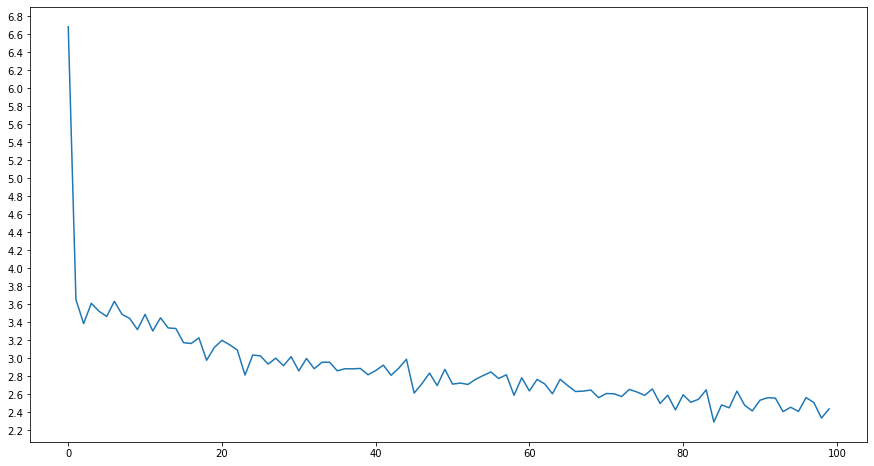

In [114]:
for iter in range(1, 30001):
    
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, 
                 encoder1, decoder1, 
                 encoder_optimizer, decoder_optimizer, 
                 criterion)
    
    print_loss_total += loss
    plot_loss_total += loss

    if iter % 1000 == 0:
        print_loss_avg = print_loss_total / 100
        print_loss_total = 0
        print('iteration - %d loss - %.4f' % (iter, print_loss_avg))

    if iter % 100 == 0:
        plot_loss_avg = plot_loss_total / 100
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

fig, ax = plt.subplots(figsize=(15, 8))
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(plot_losses)

#### KEY: > input = target < output

#### Evaluation
there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. 

In [122]:
def evaluate(encoder, decoder, sentence):
    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(0)
        
        encoder_hidden = encoder.initHidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]])  
        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden = decoder(decoder_input, 
                                                     decoder_hidden)

            topv, topi = decoder_output.data.topk(1)
            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
                
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [124]:
for i in range(10):
        
        pair = random.choice(pairs)
        
        print('>', pair[0])
        print('=', pair[1])
        
        output_words = evaluate(encoder1, decoder1, pair[0])
        output_sentence = ' '.join(output_words)
        
        print('<', output_sentence)
        print('')

> so blod bin ich nicht .
= i m not that stupid .
< i m not . . . <EOS>

> ich bin hier weil ich ihre hilfe brauche .
= i m here because i need your help .
< i m sorry i can i can t help .

> ich bin kein bisschen mude .
= i m not at all tired .
< i m not a at all . <EOS>

> er will hoch hinaus .
= he is driven .
< he s a little . . <EOS>

> er lugt .
= he is lying .
< he s a little . <EOS>

> ich spure eine gro e feindseligkeit .
= i m sensing a lot of hostility .
< i m a little . . <EOS>

> das beantwortet meine frage nicht .
= you re not answering my question .
< you re not my . . <EOS>

> die sind alle alter als sie .
= they re all older than you .
< they are as than you . <EOS>

> ich sorge mich um euch alle .
= i m worried about all of you .
< i m going to you you . <EOS>

> du hast den bezug zur realitat verloren .
= you re out of touch with reality .
< you re the only of <EOS>



In [125]:
input_sentence = 'es tut mir sehr leid' #Re-run for 'es geht mir gut'

In [128]:
output_words = evaluate(encoder1, 
                        decoder1, 
                        input_sentence)

In [129]:
print('input =', input_sentence)
print('output =', ' '.join(output_words))

input = es tut mir sehr leid
output = i m sorry about that . <EOS>
